# SQLAlchemy Homework - Surfs Up!

In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
#getting column names and types so I can see what I'm working with using inspector
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

## <font color='olivedrab'> Designing Query to retrieve the precipitation data for the last 12 months </font>


In [13]:
#find the latest date
ordered_measurement = session.query(Measurement.prcp, Measurement.date).order_by(Measurement.date.desc())
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#finding data 1 year prior = 2016-08-23

('2017-08-23')

In [14]:
#Perform Query by dates calculated above
precipitation = session.query(Measurement.date, func.avg(Measurement.prcp)).\
    filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
    group_by(Measurement.date).all()

#Saving results into Pandas DataFrame, sorting by date
rain_df = pd.DataFrame(precipitation, columns=['date', 'precipitation'])

## <font color='olivedrab'> Visualizing Query using Pandas Madplotlib </font>

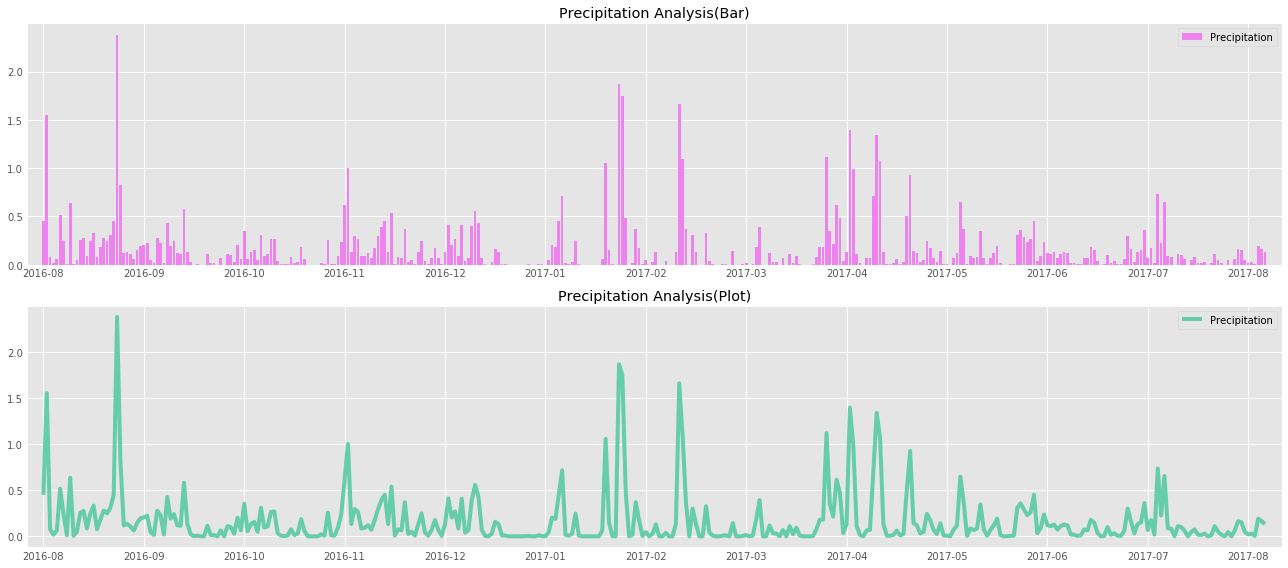

In [15]:
plt.style.use('ggplot')
x_label = ['2016-08', '2016-09', '2016-10', '2016-11', '2016-12', 
          '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', 
          '2017-06', '2017-07', '2017-08']

x_value= np.arange(len(rain_df['date']))
fig, ax = plt.subplots(nrows=2,figsize=(18, 8))
major_ticks = np.arange(0, 390, 30)
ax[0].bar(x_value, rain_df['precipitation'], color='violet')
ax[0].set_xticks(major_ticks)
ax[0].set_xticklabels(x_label)
ax[0].set_xlim(-5,370)
ax[0].legend(['Precipitation'], loc=0)
ax[0].set_title('Precipitation Analysis(Bar)')
ax[1].plot(x_value, rain_df['precipitation'], color='mediumaquamarine')
ax[1].set_xticks(major_ticks)
ax[1].set_xticklabels(x_label)
ax[1].set_xlim(-5,370)

ax[1].legend(['Precipitation'], loc=0)
ax[1].set_title('Precipitation Analysis(Plot)')

plt.tight_layout()
plt.savefig("precipitation_analysis.png", bbox_inches='tight')
plt.show()

## <font color='olivedrab'> Summary Statistics for Precipitation Data </font>

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = rain_df.describe()
summary_stats

,precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


## <font color='olivedrab'> Querying Stations, Finding Most Active </font>

In [17]:
# Designing a query to show how many stations are available in the dataset
station = session.query(func.count(Station.station)).all()
station_count = station[0][0]
station_count

9

In [18]:
#finding msot active stations (stations with most rows) and listing counts in descending order
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

## <font color='olivedrab'> Histogram of Most Active Station </font>

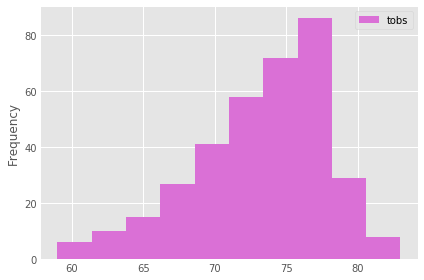

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_list = []
highest_temp = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= '2016-08-23')
temp_df = pd.DataFrame(highest_temp, columns=['tobs'])
temp_df.plot.hist(color='orchid');


plt.tight_layout()
plt.savefig("temp_analysis.png", bbox_inches='tight')
plt.show()


## <font color='olivedrab'> Creating a Function to Find Minimum, Average and Maximum Temperatures for a Given Date

In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [33]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
ct_results = calc_temps('2011-02-28', '2011-03-05')
print(ct_results)

[(61.0, 69.75510204081633, 75.0)]


## <font color='olivedrab'> Plotting Results of Function as Bar Chart

C:\conda\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


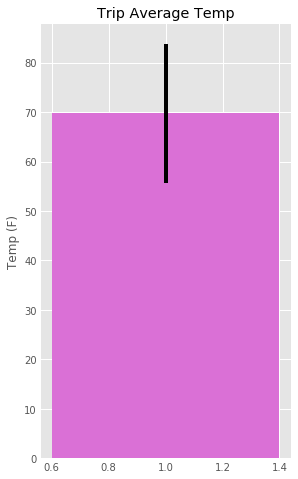

In [34]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
peak = ct_results[0][2] - ct_results[0][0]
bar = ax.bar(1, ct_results[0][1], yerr = peak, color = "orchid")
plt.title("Trip Average Temp")
plt.ylabel("Temp (F)")
plt.savefig("temp_avg.png", bbox_inches='tight')
fig.show()

## <font color='olivedrab'> Rainfall per Weather Station Query; Displaying Station Name, Lat, Long, Elevation

In [37]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Station.name,
              Station.latitude, Station.longitude, 
              Station.elevation, func.count(Measurement.prcp)).\
group_by(Measurement.station, Station.name,
              Station.latitude, Station.longitude, 
              Station.elevation).order_by(func.count(Measurement.prcp).desc()).all()

[('USC00519281',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  2772),
 ('USC00519281', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2772),
 ('USC00519281',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  2772),
 ('USC00519281',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2772),
 ('USC00519281', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2772),
 ('USC00519281',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  2772),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2772),
 ('USC00519281', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 2772),
 ('USC00519281',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2772),
 ('USC00513117',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  2696),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2696),
 ('USC00513117',
  'KUALOA RANCH HEAD